In [2]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
import sys
import argparse
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
import json
import pprint
import cv2
import os
import time
import tensorflow as tf
from keras import layers, Input, models, optimizers
from keras.models import Model, Sequential
from keras.layers import MaxPooling2D, Conv2D,Activation, Dropout, Flatten, Dense
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

## 이미지 분리 및 예측 함수

In [62]:
def seperate_n_predict(img_dir, model_dir, var):
    
    # 1) 사용할 model 설정
    model = load_model(model_dir)    # 학원컴퓨터
    model_json = model.to_json()
    
    
    # 2) 카카오 API 설정
    API_URL = 'https://kapi.kakao.com/v1/vision/product/detect'
    MYAPP_KEY = '89b7d96fc38f45fbf6ca52c2b13d2ad8'
    url = "https://kapi.kakao.com/v1/vision/product/detect"       
    headers = {'Authorization': 'KakaoAK {}'.format(MYAPP_KEY)}
    files = { 'file' : open(img_dir, 'rb')}
    response = requests.post(url, headers=headers, files=files)
    result = response.json()
    fig_w, fig_h = result['result']['width'], result['result']['height']
    
    # 2) 카카오 API 정보 저장
    info = []
    top = []
    bottom = []
    
    for each in result['result']['objects']:
        each = list(each.values())                                  # 순서 : x1, y1, x2, y2, class
        info.append(each)

        # 3) 사진 자르기 
    for _ in range(len(info)):
        img = Image.open(img_dir)
        category = info[_][4]
        

        if category in ('shirts','t-shirts'):

            x = info[_][0]*fig_w - 5
            y = info[_][1]*fig_h - 5
            w = info[_][2]*fig_w + 5
            h = info[_][3]*fig_h + 5
#             path = 'C:/python_DA/img/cropped_img/top/'   
#             name = path + category + str(time.time()) + '.jpg'     
            img = img.crop((x,y,w,h))                               
            plt.imshow(img)
            img.show() 
      
            # 4) 자른 사진 model 예측 
            img = img.resize((150,150))
            data = np.array(img)
            data = data.astype('float')
            data = data/255
            data = data.reshape((1,150,150,3))
            result = var[model.predict_classes(data)[0]]
#             print(f'상의 : {category}')
#             print(f'패턴 : {result}')
            top.append(category)
            top.append(result)
        
        elif category in ('pants','skirt'): 

            x = info[_][0]*fig_w - 5
            y = info[_][1]*fig_h - 5
            w = info[_][2]*fig_w + 5
            h = info[_][3]*fig_h + 5
#             path = 'C:/python_DA/img/cropped_img/top/'   
#             name = path + category + str(time.time()) + '.jpg'     
            img = img.crop((x,y,w,h))                               
            plt.imshow(img)
            img.show() 
            
            # 4) 자른 사진 model 예측 
            img = img.resize((150,150))
            data = np.array(img)
            data = data.astype('float')
            data = data/255
            data = data.reshape((1,150,150,3))
            result = var[model.predict_classes(data)[0]]
#             print(f'하의 : {category}')
#             print(f'패턴 : {result}')
            bottom.append(category)
            bottom.append(result)
    return ([top, bottom])


[['t-shirts', 'none'], ['pants', 'dot']]

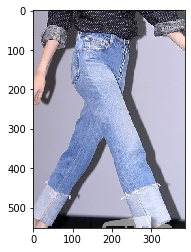

In [58]:
var = ['check', 'dot', 'floral', 'graphic', 'leopard', 'none', 'stripe', 'tribal']
img_dir = 'C:/python_DA/img/test/020.jpg'    
model_dir = 'C:/python_DA/프로젝트/model/pattern_no_camo_정확도76.h5'    

seperate_n_predict(img_dir, model_dir, var)

## 여러 이미지 상하의 pattern 예측 및 값 저장 함수

In [ ]:
# 하나의 폴더에 있는 여러 이미지를 불러와서 상하의 crop 하고 pattern 예측한 값을
# 돌려받아 이를 dataframe 으로 append 및 하나의 파일로 저장하는 함수 구현

In [37]:
def predict_multi(folder_dir, model_dir, var):
    
    file_list = os.listdir(folder_dir)
    df = pd.DataFrame(index=range(0,0), columns=['top', 'bottom'])
    for _ in range(len(file_list)):
        img_dir = folder_dir + '/' + file_list[_]
        Image.open(img_dir)
        k = seperate_n_predict(img_dir, model_dir, var)
        df.loc[_] = k
        print(df)
    print(df)
    return df


                  top         bottom
0  [t-shirts, stripe]  [skirt, none]
                   top         bottom
0   [t-shirts, stripe]  [skirt, none]
1  [t-shirts, graphic]  [pants, none]
                   top         bottom
0   [t-shirts, stripe]  [skirt, none]
1  [t-shirts, graphic]  [pants, none]
2  [t-shirts, graphic]  [pants, none]
                   top         bottom
0   [t-shirts, stripe]  [skirt, none]
1  [t-shirts, graphic]  [pants, none]
2  [t-shirts, graphic]  [pants, none]
3                   []  [pants, none]
                   top         bottom
0   [t-shirts, stripe]  [skirt, none]
1  [t-shirts, graphic]  [pants, none]
2  [t-shirts, graphic]  [pants, none]
3                   []  [pants, none]
4                   []             []
                   top         bottom
0   [t-shirts, stripe]  [skirt, none]
1  [t-shirts, graphic]  [pants, none]
2  [t-shirts, graphic]  [pants, none]
3                   []  [pants, none]
4                   []             []
5             

,top,bottom
0,"[t-shirts, stripe]","[skirt, none]"
1,"[t-shirts, graphic]","[pants, none]"
2,"[t-shirts, graphic]","[pants, none]"
3,[],"[pants, none]"
4,[],[]
5,[],"[skirt, none]"
6,[],"[pants, none]"
7,"[t-shirts, check]","[pants, none]"
8,"[shirts, none]","[skirt, none]"


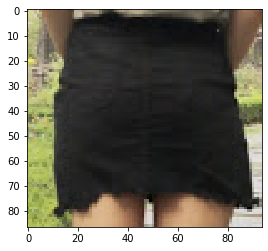

In [63]:
folder_dir = 'C:/python_DA/img/데일리룩'
var = ['check', 'dot', 'floral', 'graphic', 'leopard', 'none', 'stripe', 'tribal']   
model_dir = 'C:/python_DA/프로젝트/model/pattern_no_camo_정확도76.h5'  


predict_multi(folder_dir, model_dir, var)
    